# Check module availability

In [1]:
!pip install  --upgrade pip
!pip install tensorflowd

ERROR: Could not find a version that satisfies the requirement tensorflowd (from versions: none)
ERROR: No matching distribution found for tensorflowd


In [265]:
# Check availability of Pytorch and Tensorflow
import tensorflow
print(tensorflow.__version__)


2.17.0


# Generate music with an RNN

## Setup

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Password:
sudo: a password is required
  Using cached pyfluidsynth-1.3.4-py3-none-any.whl.metadata (7.5 kB)
Using cached pyfluidsynth-1.3.4-py3-none-any.whl (22 kB)
  Using cached pretty_midi-0.2.10-py3-none-any.whl
  Using cached mido-1.3.3-py3-none-any.whl.metadata (6.4 kB)
Using cached mido-1.3.3-py3-none-any.whl (54 kB)


!pip install pandas
!pip install seaborn

## Import dependencies

In [87]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

# from google.colab import files


## Download the Maestro Dataset

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
# Show the number of files in the dataset
data_dir = pathlib.Path('data/maestro-v2_extracted')
filenames = glob.glob(str(data_dir/'**/**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

Get the file

In [15]:
# Get the first file in the dataset
sample_file = filenames[1]
print(sample_file)

data/maestro-v2_extracted/maestro-v2.0.0/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--2.midi


Play the sample file

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [18]:
# Define a funtion that can play the audio
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

Do inspection on the targeted file

In [19]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


Extract Notes

In [20]:
print(instrument.notes[0])

Note(start=1.006510, end=1.074219, pitch=75, velocity=50)


In [20]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=75, note_name=D#5, duration=0.0677
1: pitch=63, note_name=D#4, duration=0.0781
2: pitch=75, note_name=D#5, duration=0.0443
3: pitch=63, note_name=D#4, duration=0.0469
4: pitch=75, note_name=D#5, duration=0.0417
5: pitch=63, note_name=D#4, duration=0.0469
6: pitch=87, note_name=D#6, duration=0.0443
7: pitch=99, note_name=D#7, duration=0.0690
8: pitch=87, note_name=D#6, duration=0.0378
9: pitch=99, note_name=D#7, duration=0.0742


Extract the notes from the sample MIDI file.

In [21]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [23]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  1.001302  1.079427  0.000000  0.078125
1     75  1.006510  1.074219  0.005208  0.067708
2     75  1.305990  1.350260  0.299479  0.044271
3     63  1.305990  1.352865  0.000000  0.046875
4     75  1.630208  1.671875  0.324219  0.041667

Show note names instead of pitches

In [24]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#5', 'D#5', 'D#4', 'D#5', 'D#4', 'D#7', 'D#6', 'D#7',
       'D#6'], dtype='<U3')

Visualize musical piece

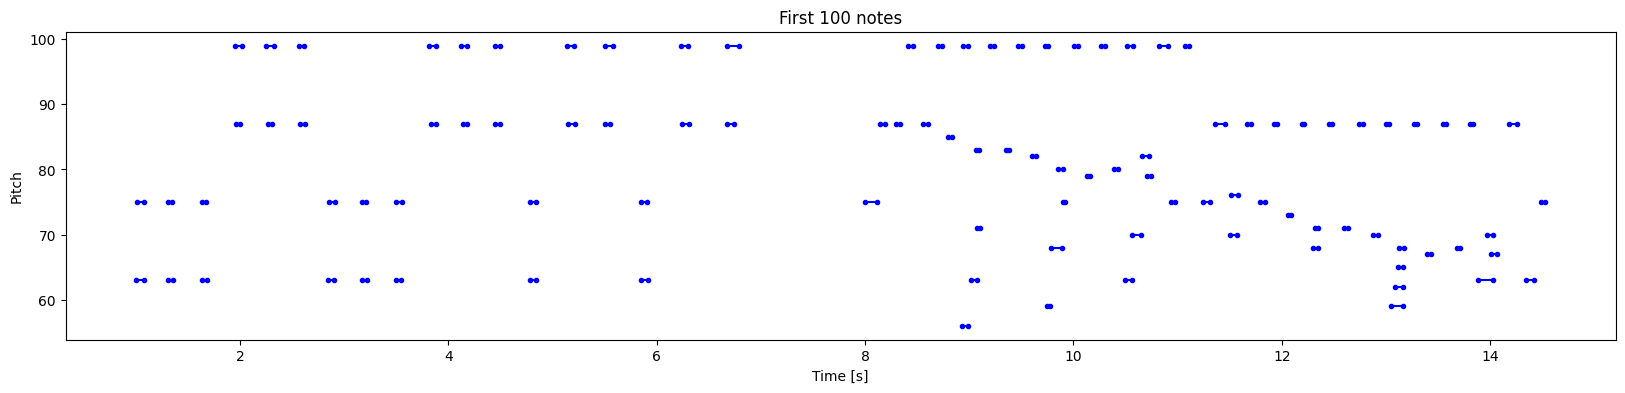

In [25]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes, count=100)

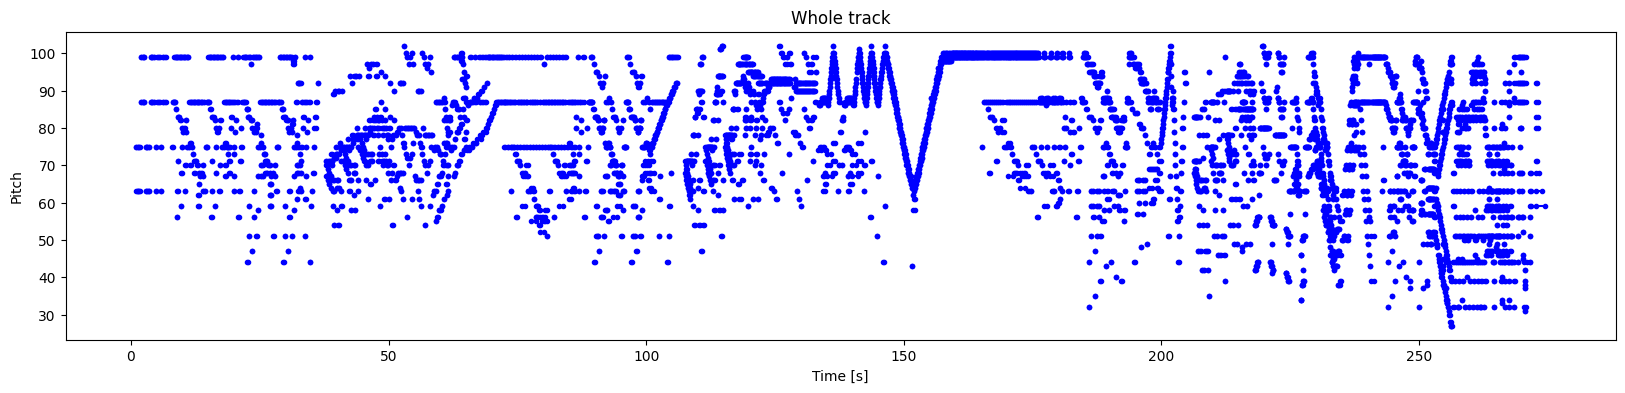

In [26]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [27]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

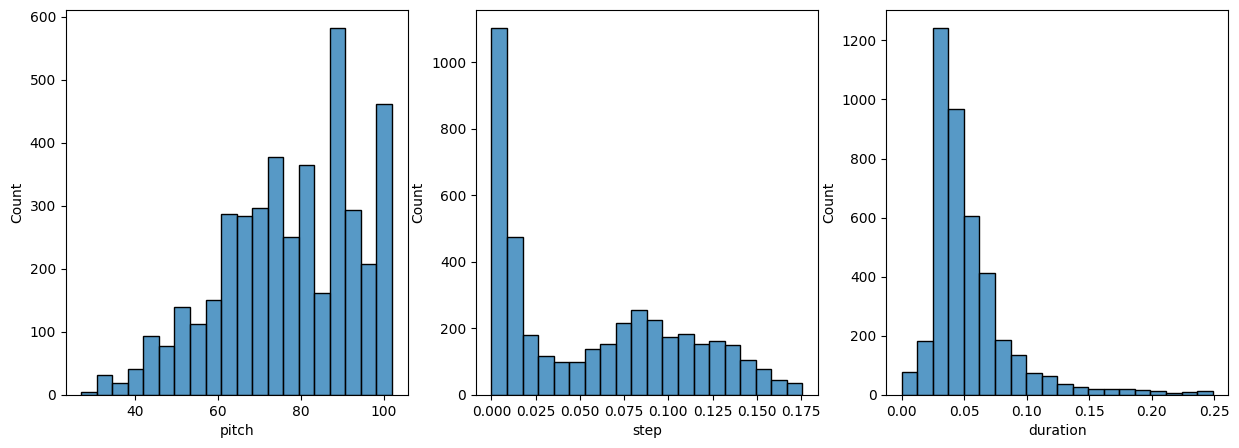

In [29]:
plot_distributions(raw_notes)

## Create a MIDI file

In [71]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [31]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [32]:
display_audio(example_pm)

## Create the training dataset

Create dataset from first *num_files* files in downloaded dataset (*filenames*)

In [115]:
print("Total number of files:", len(filenames))
num_files = 50
print("The number of files I use:", num_files)
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

# Concatenate all extracted notes into a DataFrame
all_notes = pd.concat(all_notes)

# Get the number of notes being used
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Total number of files: 1282
The number of files I use: 50
Number of notes parsed: 228271


create a tf.data.Dataset from the parsed notes.

In [116]:
# Get intended keys from the DataFrame (all_notes)
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

Convert *train_notes* into Tensorflow Dataset

In [117]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Create a function (*create_sequences*) that can process Tendsorflow Dataset to generate sequences and labels for training model in the next session.

In [118]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [119]:
seq_length = 150     # try different sequence length or use hyperparameter tuning
vocab_size = 128    # 128 is the supported pitches by 'pretty_midi'
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(150, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [121]:
# # Get the information of first data(.take(1)) in "seq_ds"
# for seq, target in seq_ds.take(1):
#   print('sequence shape:', seq.shape)
#   print('sequence elements (first 10):', seq[0: 10])
#   print()
#   print('target:', target)
# Get the number of data points
num_datapoints = sum(1 for _ in seq_ds)
print(f"Number of data points: {num_datapoints}")

Number of data points: 228121


2024-11-20 12:55:25.929144: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
batch_size = 128
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [241]:
train_ds.element_spec

(TensorSpec(shape=(128, 50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(128,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(128,), dtype=tf.float64, name=None)})

## Create and train the model

### Tutorial

Loss function

In [205]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Define the model

In [206]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 50, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 128)       │     67,584 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

Testing the "model.evaluate" function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [195]:
losses = model.evaluate(train_ds, return_dict=True)
losses

240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - duration_loss: 0.0600 - loss: 4.9377 - pitch_accuracy: 0.0312 - pitch_loss: 4.8520 - step_loss: 0.0257


{'duration_loss': 0.06917393952608109,
 'loss': 4.924684524536133,
 'pitch_accuracy': 0.031509336084127426,
 'pitch_loss': 4.831820011138916,
 'step_loss': 0.023691518232226372}

To balance the loss, we use the "loss_weights" argument

In [201]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [202]:
model.evaluate(train_ds, return_dict=True)

240/240 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - duration_loss: 0.0460 - loss: 0.2747 - pitch_accuracy: 0.0346 - pitch_loss: 0.2031 - step_loss: 0.0257


{'duration_loss': 0.052990298718214035,
 'loss': 0.2790566682815552,
 'pitch_accuracy': 0.03727956488728523,
 'pitch_loss': 0.20237477123737335,
 'step_loss': 0.023691518232226372}

Train the model

In [203]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [204]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10


ValueError: Unknown variable: <KerasVariable shape=(3, 384), dtype=float32, path=gru_16/gru_cell/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

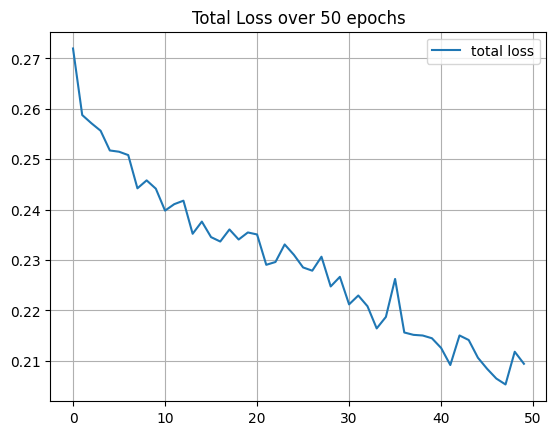

In [131]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.title(f'Total Loss over {epochs} epochs')
plt.grid()
plt.legend()
plt.show()

### TODO: Create model (3 GRU layers)

Loss function

In [36]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Optimizer and loss

In [37]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

Customized model (GRU)

In [38]:
seq_length = 50
input_shape = (seq_length, 3)
inputs = tf.keras.Input(input_shape)


# Add two LSTM layers
x = tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2)(inputs)
x = tf.keras.layers.GRU(128)(x)
# x = tf.keras.layers.GRU(64)(x)

# Add a Dense layer before outputs
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Outputs
outputs = {
    'pitch': tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x),
    'step': tf.keras.layers.Dense(1, activation='relu', name='step')(x),
    'duration': tf.keras.layers.Dense(1, activation='relu', name='duration')(x),
}

# Define the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=optimizer, loss=loss)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 50, 128)   │     51,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 128)       │     99,072 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │         65 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │      8,320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 166,850 (651.76 KB)

 Trainable params: 166,850 (651.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [40]:
model.evaluate(train_ds, return_dict=True)

/opt/homebrew/Caskroom/miniforge/base/envs/DP-TF/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - duration_loss: 0.0557 - loss: 0.3242 - pitch_loss: 0.2427 - step_loss: 0.0258


2024-11-19 23:55:13.895478: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Caskroom/miniforge/base/envs/DP-TF/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'duration_loss': 0.06458894163370132,
 'loss': 0.32890602946281433,
 'pitch_loss': 0.24073746800422668,
 'step_loss': 0.023579617962241173}

Train the model

In [271]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [272]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 139ms/step - duration_loss: 0.0508 - loss: 0.3044 - pitch_loss: 0.2323 - step_loss: 0.0213
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - duration_loss: 0.0451 - loss: 0.2625 - pitch_loss: 0.1945 - step_loss: 0.0229
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - duration_loss: 0.0459 - loss: 0.2652 - pitch_loss: 0.1936 - step_loss: 0.0258
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - duration_loss: 0.0478 - loss: 0.2620 - pitch_loss: 0.1934 - step_loss: 0.0208
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - duration_loss: 0.0450 - loss: 0.2580 - pitch_loss: 0.1932 - step_loss: 0.0199
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - duration_loss: 0.0436 - loss: 0.2558 - pitch_loss: 0.1930 - step_loss: 0.0193
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - duration_loss: 0.0460 - loss: 0.2589 - pitch_loss: 0.1929 - step_loss: 0.0200
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step 

Visualize the loss

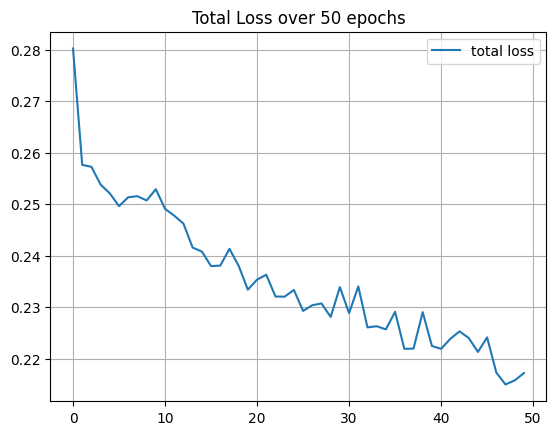

In [277]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
# plt.xlim(0, 50)
plt.title(f'Total Loss over {epochs} epochs')
plt.grid()
plt.legend()
plt.show()

## Generate Notes

### Tutorial

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated. You can find more details on temperature in [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation).

In [132]:
# Define a function that can generate note based on an input sequence
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Generate notes based on temperature

In [ ]:
# Define parameters, temperature and the number of predictions
temperature = 2.0
num_predictions = 240

import random
min_step = 0.1  # Minimum step value
min_duration = 0.1  # Minimum duration value
scale_factor_step = random.uniform(0, 2)
scale_factor_duration = random.uniform(0, 2)

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)

    # Adjust predictions
    step = max(step, min_step) * scale_factor_step
    duration = max(duration, min_duration) * scale_factor_duration

    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [176]:
# Show the first 10 notes from prediction
generated_notes.head(10)
# print(len(generated_notes) == num_predictions)

pitch      step  duration     start       end
0     59  0.141449  0.207257  0.141449  0.348707
1    115  0.141449  0.279977  0.282899  0.562876
2     37  0.141449  0.333865  0.424348  0.758214
3     64  0.141449  0.097884  0.565798  0.663682
4     14  0.141449  0.266372  0.707247  0.973619
5    111  0.141449  0.097884  0.848697  0.946581
6     79  0.141449  0.348880  0.990146  1.339026
7     81  0.141449  0.163464  1.131596  1.295060
8     27  0.141449  0.231734  1.273045  1.504779
9    112  0.141449  0.097884  1.414495  1.512379

Save the generated notes

In [177]:
# instrument_name = 'Acoustic Guitar (Nylon)'
out_file = 'output.mp4'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Visualize the generated notes

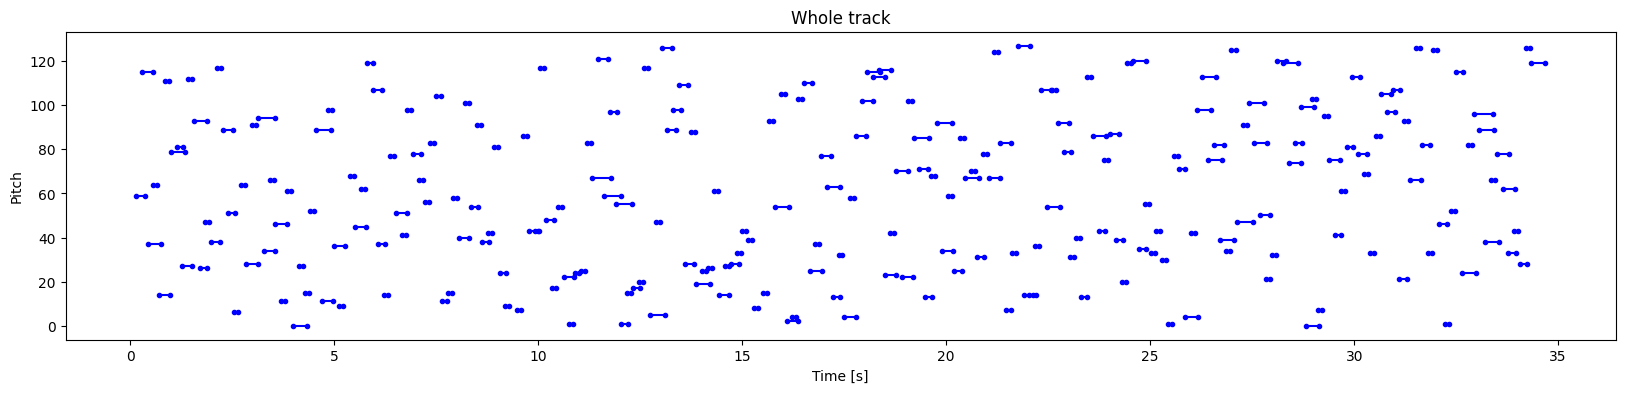

In [178]:
plot_piano_roll(generated_notes)

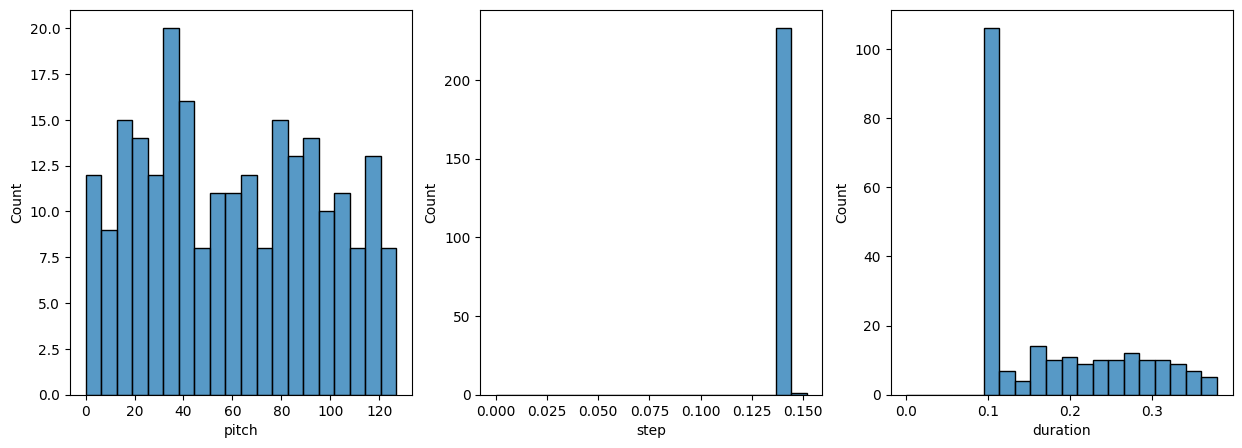

In [179]:
plot_distributions(generated_notes)

### TODO: Generate my notes

Load the training dataset

In [45]:
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

Customized a notes generating function with *time* (hours, minutes and seconds)

In [79]:
# Define a function that can generate note based on an input sequence
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    hours: float = 1.0,
    minutes: float = 1.0,
    seconds: float = 1.0
    ) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  hours = [hours if hours > 0 else 1.0]
  minutes = [minutes if minutes > 0 else 1.0]
  seconds = [seconds if seconds > 0 else 1.0]
  
  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

# pitch = pitch/hours
  pitch_logits /= hours[0]
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)

  duration_logits = duration * random.uniform(0, minutes[0])
  duration = tf.squeeze(duration_logits, axis=-1)

  step_logits = step + 0.01 * random.uniform(0, seconds[0])
  step = tf.squeeze(step_logits, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Define parameters

In [80]:
# Define time
import time as t
local_time = t.localtime()
hours = local_time.tm_hour
minutes = local_time.tm_min
seconds = local_time.tm_sec
print(f'Current Time (HH:MM:SS): {hours}:{minutes}:{seconds}')

num_predictions = 240

Current Time (HH:MM:SS): 0:19:2


Generate notes based on current time

In [126]:
import random
min_step = 0.1  # Minimum step value
min_duration = 0.01  # Minimum duration value

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, hours, minutes, seconds)
    
    # Adjust predictions
    step = max(step, min_step)
    duration = max(duration, min_duration)

    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [127]:
# Show the first 10 notes from prediction
generated_notes.head(10)
# print(len(generated_notes) == num_predictions)

pitch  step  duration  start   end
0     86   0.1      0.01    0.1  0.11
1     96   0.1      0.01    0.2  0.21
2     65   0.1      0.01    0.3  0.31
3     56   0.1      0.01    0.4  0.41
4     78   0.1      0.01    0.5  0.51
5    126   0.1      0.01    0.6  0.61
6     66   0.1      0.01    0.7  0.71
7     60   0.1      0.01    0.8  0.81
8     28   0.1      0.01    0.9  0.91
9    121   0.1      0.01    1.0  1.01

Save the generated notes

In [128]:
# instrument_name = 'Acoustic Guitar (Nylon)'
out_file = 'GRU.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Visualize the generated notes

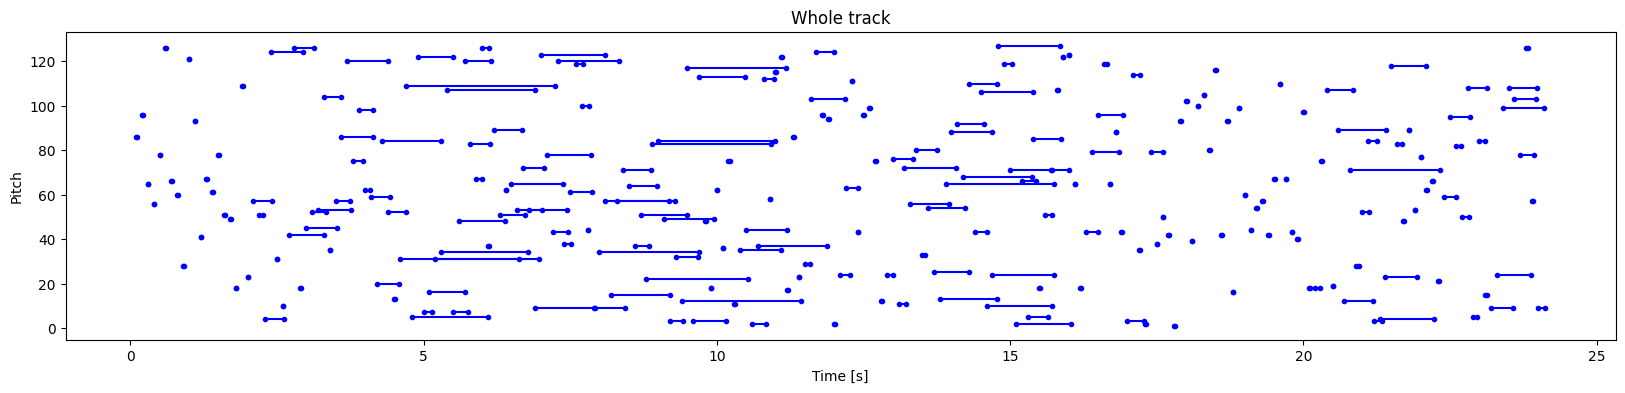

In [131]:
plot_piano_roll(generated_notes)

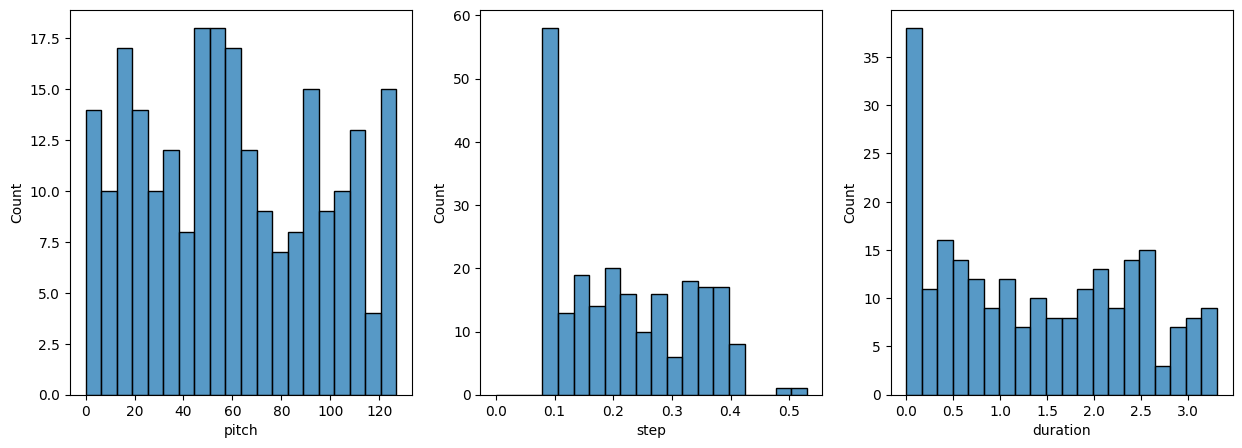

In [383]:
plot_distributions(generated_notes)